In [19]:
import Pkg; Pkg.add(["Plots", "Polynomials"]);
import Logging; Logging.disable_logging(Logging.Info)

   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [7]:
const STATIC_LECTURE = false;

In [18]:
using LinearAlgebra;
using Plots; default(l=5, size=(900,550), label=false);
using Printf;
using Polynomials;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

### Warmup

Give $2 \times 2$ examples of:

- A nondegenerate matrix
- A degenerate matrix
- A normal matrix
- A matrix with real entries and complex eigenvalues

# Overview of Eigenvalue Algorithms

## Review

- **Eigenvalues / eigenvectors:** There is $x \neq 0$ such that $A x = \lambda x$ $\Leftrightarrow$ $\lambda$ is a root of $p_A(z) = \det(z I - A)$
  - Fundamental theorem of algebra $\Rightarrow$ $A \in \mathbb{C}^{m \times m}$ has $m$ eigenvalues counting with **algebraic multiplicity**

- **Eigenspace** is subspace $E_\lambda$ such tha $A x = \lambda x$ for all $x \in E_\lambda$
  - $\mathrm{dim}(E_\lambda)$ is the **geometric multiplicity**

- geometric multiplicity of $\lambda$ $\leq$ algebraic multiplicity of $\lambda$
  - if strictly less $\lambda$ and $A$ are defective

- $A$ is not defective $\Leftrightarrow$ $A$ has an **eigenvalue decomposition,**

$$A = X \Lambda X^{-1}, \quad \Lambda \text{ diagonal}.$$

  - Furthermore $X = Q$ is unitary $\Leftrightarrow$ $A$ is **normal**, $$A A^* = A^* A \quad\Leftrightarrow\quad
  A = Q \Lambda Q^*$$

- Every square matrix $A \in \mathbb{C}^{m \times m}$ has a **Schur factorization**,
  $$ A = Q T Q^*, \quad T \text{ upper triangular}.$$
  - Eigenvalues are on the diagonal of $T$
  - Schur factorization is complex even if $A$ is real

- Defining the **companion matrix** C_p of $p(z) = z^m + a_{m-1} z^{m-1} + \cdots + z_0$,
$$
C_p = \begin{bmatrix}
& & & & & -a_0 \\
1 & & & & & -a_1 \\
& 1 & & & & -a_2 \\
& & 1 &  & & \vdots \\
& & & \ddots & & -a_{m-2} \\
& & & & 1 & -a_{m-1}
\end{bmatrix}$$
the roots of $p$ are the eigenvalues of $A$.
  

In [27]:
function roots_by_companion(a)
    """
    a = (a₀, a₁, …, aₘ₋₁)
    """
    m = length(a)
    C = zeros(eltype(a),m,m)
    C[:,m] = -a
    for i in 2:m
        C[i,i-1] = 1
    end
    return eigvals(C)
end

roots_by_companion (generic function with 1 method)

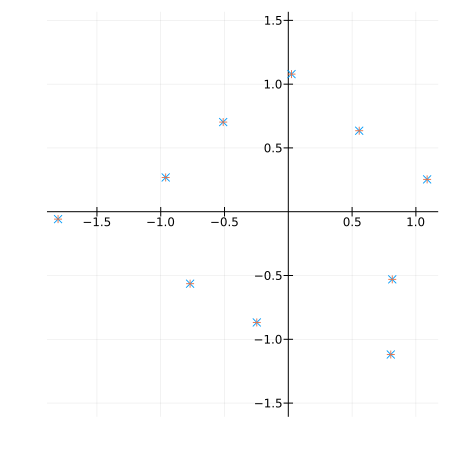

In [44]:
m = 10
as = randn(Complex{Float64},m)
p = Polynomial([as;1])
direct = roots(p)
comp = roots_by_companion(as)
plot(real.([direct comp]), imag.([direct comp])
    , aspect_ratio = :equal
    , st = scatter
    , m = [:x :+]
    , framestyle = :origin
    , size = (450,450)
    )

  - $\Rightarrow$ an **eigenvalue algorithm** is a **root finding algorithm**
  - $\Rightarrow$ an **eigenvalue algorithm must be iterative**

## Example of an iterative eigenvalue algorithm: Power Iteration

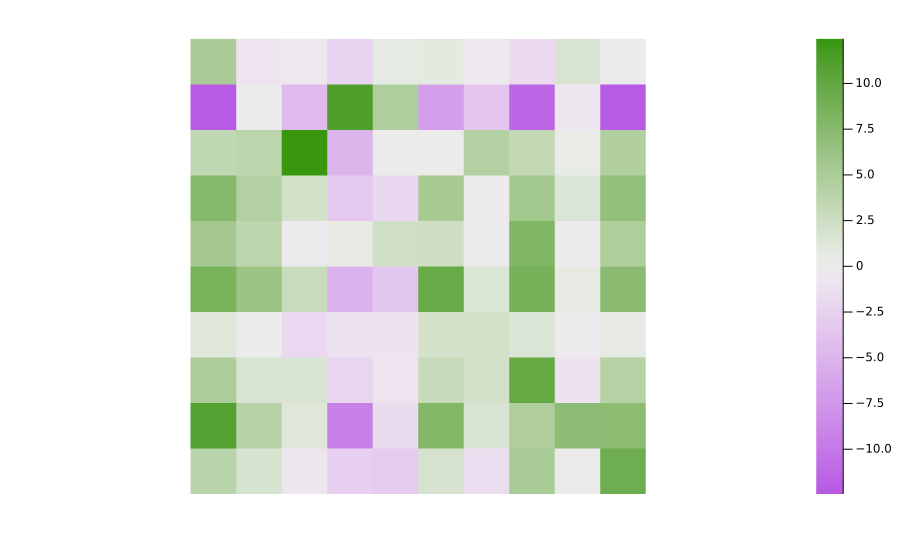

In [92]:
m = 10
Λ = Diagonal(collect(1:m))
X = randn(m, m)
A = (X * Λ) / X
scale = maximum(abs.(A))
imshow(A, clim=(-scale,scale))

In [93]:
x_init = randn(m)
x_init /= norm(x)

10-element Vector{Float64}:
  0.6387070972121367
  0.2759207126108639
  1.6382052269553964
 -0.8265848035194938
 -0.0708250965581194
 -0.6126115896762018
  0.19732092688702005
  1.8178351952073017
  0.6237808945977183
 -0.1909491214775616

In [94]:
x = copy(x_init)
n_iter = 10
for i in 1:n_iter
    Ax = A * x
    λ = norm(Ax)
    display(λ)
    x = Ax / λ
end

73.40218632947722

10.742287800924405

9.13339646124146

8.82800459984502

8.785824844691644

8.80829062034391

8.843931165964449

8.879157497005934

8.911081767256219

8.93974941444652

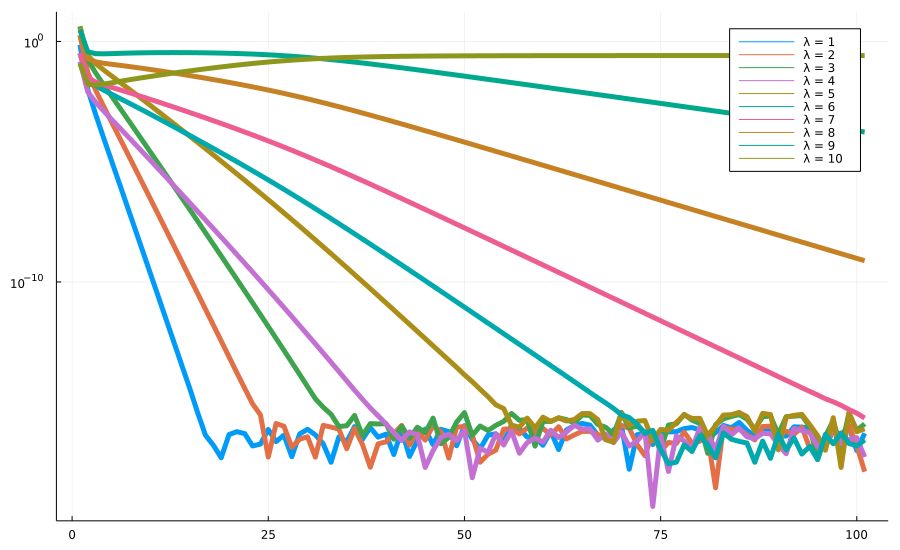

In [96]:
x = copy(x_init)
n_iter = 100
c = zeros(m, n_iter+1)
for i in 1:n_iter
    c[:,i] = X \ x
    Ax = A * x
    λ = norm(Ax)
    x = Ax / λ
end
c[:,end] = X \ x
plot(1:(n_iter+1), abs.(c)', yscale=:log10, labels=["λ = $j" for i in 1:1, j in 1:m])

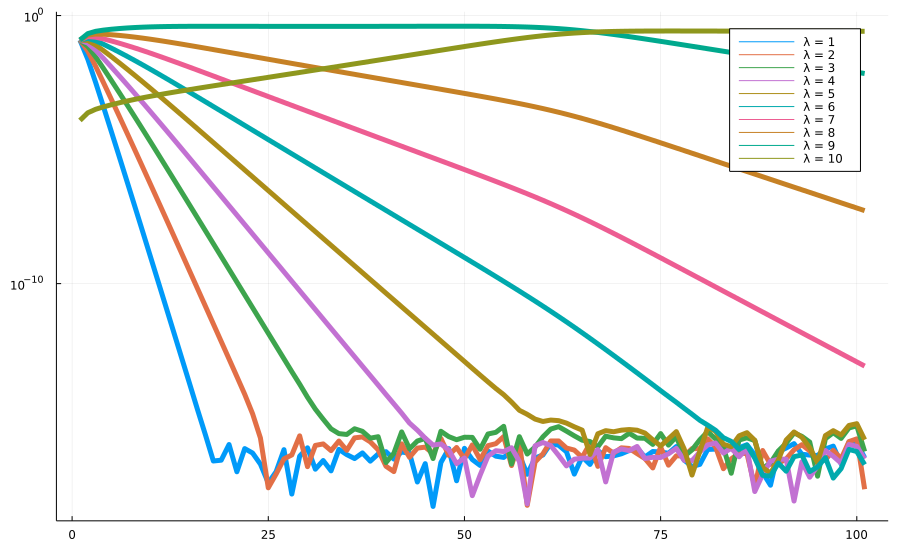

In [98]:
c_init = ones(m)
c_init[m] = 1.e-3
x_init = X * c_init
x = x_init / norm(x_init)
n_iter = 100
c = zeros(m, n_iter+1)
for i in 1:n_iter
    c[:,i] = X \ x
    Ax = A * x
    λ = norm(Ax)
    x = Ax / λ
end
c[:,end] = X \ x
plot(1:(n_iter+1), abs.(c)', yscale=:log10, labels=["λ = $j" for i in 1:1, j in 1:m])

- What about a matrix with real entries and complex eigenvalues?

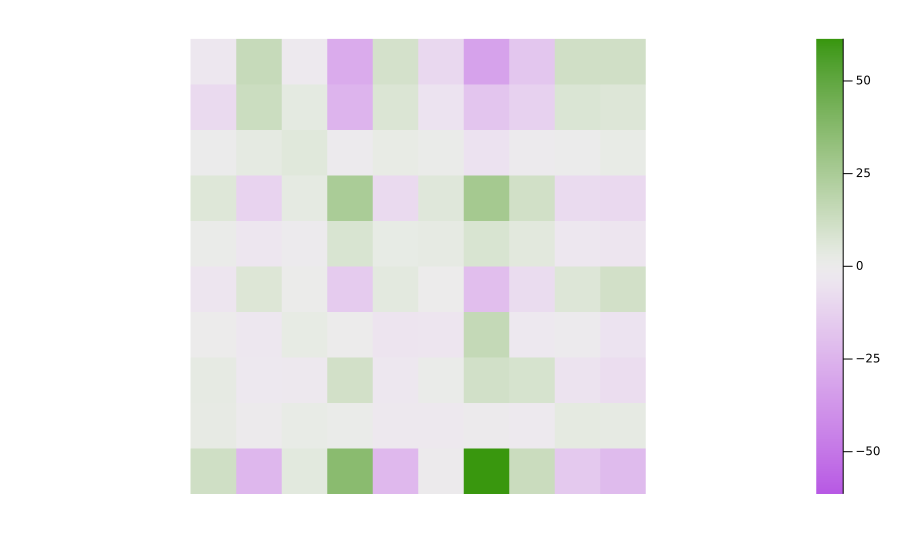

In [131]:
m = 10
Λ = diagm(collect(1.0:m))
Λ[m-1:m,m-1:m] = m * [[1.0,1.0] [-1.0,1.0]] / sqrt(2)
X = randn(m, m)
A = (X * Λ) / X
scale = maximum(abs.(A))
imshow(A, clim=(-scale,scale))

In [132]:
eigvals(A)

10-element Vector{ComplexF64}:
 0.9999999999999958 + 0.0im
  2.000000000000003 + 0.0im
  2.999999999999982 + 0.0im
 3.9999999999999782 + 0.0im
  5.000000000000041 + 0.0im
  6.000000000000048 + 0.0im
  6.999999999999978 + 0.0im
  7.071067811865454 - 7.071067811865471im
  7.071067811865454 + 7.071067811865471im
  8.000000000000005 + 0.0im

In [133]:
x = randn(m)
x /= norm(x)
n_iter = 10
for i in 1:n_iter
    j = argmax(abs.(x))
    Ax = A * x
    λ = Ax[j] / x[j]
    display(λ)
    x = Ax / λ
end

4.9663362284209365

6.909806764425735

7.449658004102768

8.632941192557324

10.284849523363134

6.2975459838954695

0.4300818900014534

9.093111701164016

3.4169696524524587

6.2936346447420455

In [134]:
x = randn(Complex{Float64}, m)
x /= norm(x)
n_iter = 10
for i in 1:n_iter
    j = argmax(abs.(x))
    Ax = A * x
    λ = Ax[j] / x[j]
    display(λ)
    x = Ax / norm(Ax)
end

15.911752528353626 + 44.64996551419899im

8.897784172941554 - 0.6543648468387216im

10.14759285145066 - 0.7025576170805118im

5.1246004003639145 - 0.6975470574305662im

14.86141417117345 - 2.4901999228853184im

8.082451679696167 - 0.7114909518540744im

2.3140512081151305 - 0.6827851650047286im

4.915018255909008 - 0.8447566581271093im

17.13918054504795 - 1.7472539627376842im

8.157444930802448 - 0.7480211880474039im

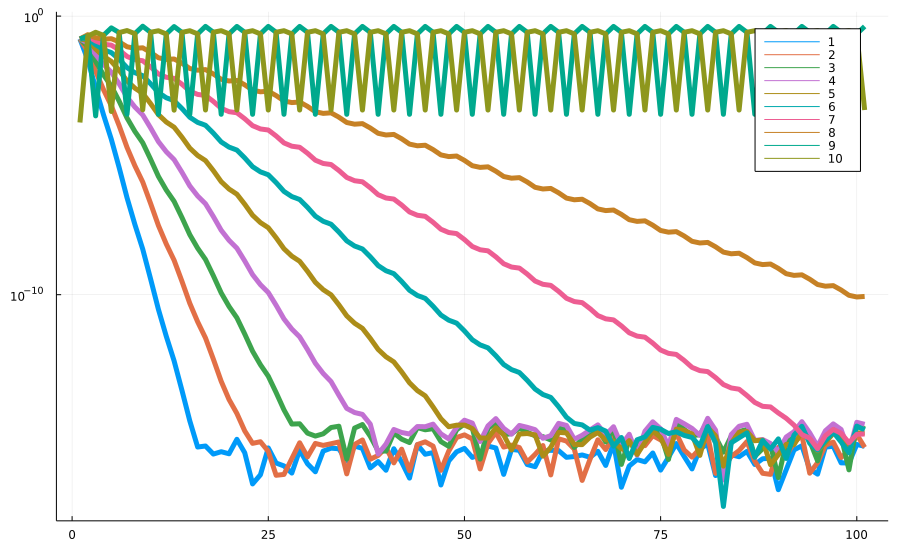

In [135]:
c_init = ones(m)
c_init[m] = 1.e-3
x_init = X * c_init
x = x_init / norm(x_init)
n_iter = 100
c = zeros(m, n_iter+1)
for i in 1:n_iter
    c[:,i] = X \ x
    Ax = A * x
    x = Ax / norm(Ax)
end
c[:,end] = X \ x
plot(1:(n_iter+1), abs.(c)', yscale=:log10, labels=["$j" for i in 1:1, j in 1:m])

> The best general purpose eigenvalaue algorithms are [...] the computation of an eigenvalue-revealing factorization of $A$, where the eigenvalues appear as entries of one of the factors.

## Schur factorization and Diagonalization

We compute a Schur factorization $A = QTQ^*$ by transforming $A$ by a sequence of elementary unitary similarity transformations $X \mapsto Q_j^* X Q_j$.  We want

$$
\underbrace{Q_j^* \cdots Q_2^* Q_1^*}_{Q^*} A \underbrace{Q_1 Q_2 \cdots Q_j}_{Q}
$$

to converge rapidly to an upper triangular matrix $T$ as $j \to \infty$.

**Claim.** If $A$ is a normal matrix, $T$ is diagonal.

### Two phases of eigenvalue computations

1. A direct method is applied to produce an **upper Hessenberg matrix** (a matrix with zeros below the main diagonal)

$$
H = \begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
& \times & \times & \times & \times \\
& & \times & \times & \times \\
& & & \times & \times \\
\end{bmatrix}
$$

2. An iteration is appled to generate a (formally infinite) sequence of Hessenberg matrices that converges to a triangular form.

### $A$ is nonhermitian

$$
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\end{bmatrix}}_{A}
\quad
\stackrel{\text{Phase 1}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
& \times & \times & \times & \times \\
& & \times & \times & \times \\
& & & \times & \times \\
\end{bmatrix}}_{H}
\quad
\stackrel{\text{Phase 2}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
& \times & \times & \times & \times \\
& & \times & \times & \times \\
& & & \times & \times \\
& & & & \times \\
\end{bmatrix}}_{T}
$$

- Phase 1: $O(m^3)$ operations
- Phase 2: $O(m^2)$ operations **per iteration** ($O(m^3)$ if we did not do phase 1)

### $A$ is hermitian

$$
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\end{bmatrix}}_{A}
\quad
\stackrel{\text{Phase 1}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times & & & \\
\times & \times & \times & & \\
& \times & \times & \times & \\
& & \times & \times & \times \\
& & & \times & \times \\
\end{bmatrix}}_{T}
\quad
\stackrel{\text{Phase 2}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times &  &  &  & \\
& \times & & & \\
& & \times & & \\
& & & \times & \\
& & & & \times \\
\end{bmatrix}}_{D}
$$

- Phase 1: $O(m^3)$ operations
- Phase 2: $O(m)$ operations **per iteration** ($O(m^3)$ if we did not do phase 1)

### Exercise

**T&B Exercise 25.1.** 

- Let $A \in \mathbb{C}^{m \times m}$ be tridiagonal and Hermitian, with all its sub- and superdiagonal entries nonzero.  Prove that the eigenvalues of $A$ are distinct.

- Let $A$ be upper-Hessenberg, with all its subdigonal entries nonzero.  Give an example that shows that the eigenvalues of $A$ are not necessarily distinct.

## Reduction to Hessenberg or Tridiagonal Form

### A Bad Idea

We cannot be too greedy when trying to make the matrix triangular

$$
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ
\end{bmatrix}}_{A}
\quad
\stackrel{Q_1^*}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\bullet & \bullet & \bullet & \bullet & \bullet \\
 & \bullet & \bullet & \bullet & \bullet \\
  & \bullet & \bullet & \bullet & \bullet \\
   & \bullet & \bullet & \bullet & \bullet \\
    & \bullet & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_1^* A}
\quad
$$

$$
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ
\end{bmatrix}}_{Q_1^* A}
\quad
\stackrel{Q_1}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\bullet & \bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_1^* A Q_1}
\quad
$$

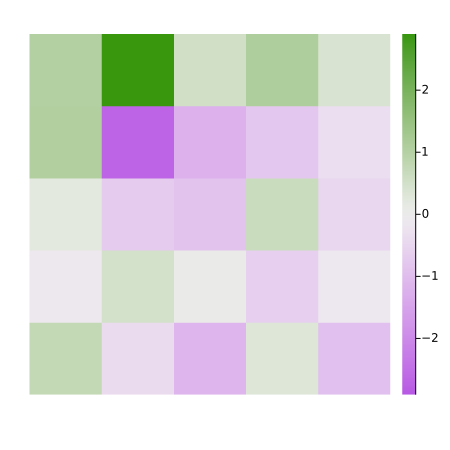

In [158]:
m = 5
A = randn(m,m)
scale = maximum(abs.(A))
imshow(A, clim=(-scale, scale), size=(450,450))

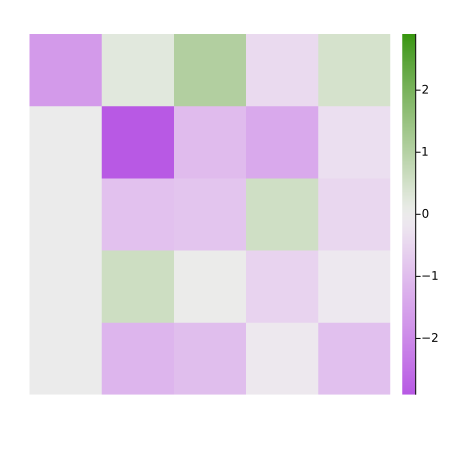

In [159]:
q = A[:,1]
z = copy(q)
z[1] += sign(q[1]) * norm(q)
Q = I - 2. * z * z' / (z' * z)
QA = Q' * A
imshow(QA, clim=(-scale,scale), size=(450,450))

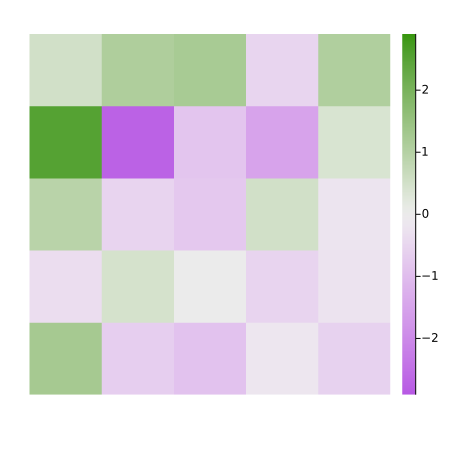

In [160]:
QAQ = QA * Q
imshow(QAQ, clim=(-scale,scale), size=(450,450))

- This had to fail: otherwise we would have a direct computation of eigenvalues

### A Good Idea

$$
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ
\end{bmatrix}}_{A}
\quad
\stackrel{Q_1^*}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\bullet & \bullet & \bullet & \bullet & \bullet \\
 & \bullet & \bullet & \bullet & \bullet \\
  & \bullet & \bullet & \bullet & \bullet \\
   & \bullet & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_1^* A}
\quad
$$

$$
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ
\end{bmatrix}}_{Q_1^* A}
\quad
\stackrel{Q_1}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\circ & \bullet & \bullet & \bullet & \bullet \\
\circ & \bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_1^* A Q_1}
\quad
$$

(4, 4)

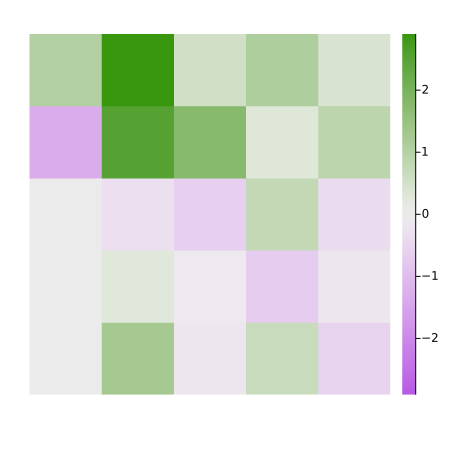

In [161]:
q = A[2:end,1]
z = copy(q)
z[1] += sign(q[1]) * norm(q)
Q = I - 2. * z * z' / (z' * z)
display(size(Q))
QA = [A[[1],:]; Q' * A[2:end,:]]
imshow(QA, clim=(-scale,scale), size=(450,450))

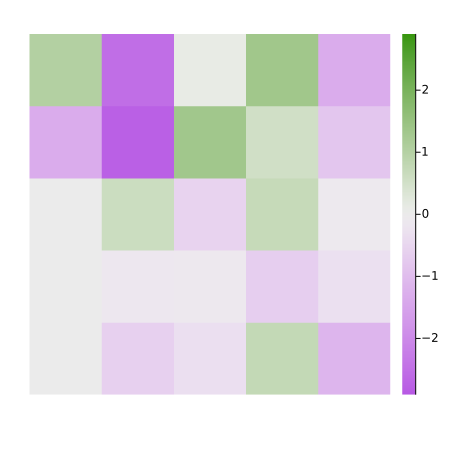

In [162]:
QAQ = [QA[:,1] QA[:,2:end] * Q]
imshow(QAQ, clim=(-scale,scale), size=(450,450))

$$
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
& \circ & \circ & \circ & \circ \\
& \circ & \circ & \circ & \circ \\
& \circ & \circ & \circ & \circ
\end{bmatrix}}_{Q_1^* A Q_1}
\quad
\stackrel{Q_2^*}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
 & \bullet & \bullet & \bullet & \bullet \\
  & & \bullet & \bullet & \bullet \\
   & & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_2^* Q_1^* A Q_1}
\quad
\stackrel{Q_2}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\circ & \circ & \bullet & \bullet & \bullet \\
\circ & \circ & \bullet & \bullet & \bullet \\
& \circ & \bullet & \bullet & \bullet \\
& & \bullet & \bullet & \bullet \\
& & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_2^* Q_1^* A Q_1 Q_2}
$$

In [185]:
function householder_to_hessenberg(A)
    m = size(A)[1]
    Q = Matrix(one(eltype(A))*I,m,m)
    H = copy(A)
    for k in 1:m-2
        x = H[k+1:m,k]
        vₖ = copy(x)
        vₖ[1] += norm(x) * sign(x[1])
        vₖ /= norm(vₖ)
        H[k+1:m,k:m] -= 2 * vₖ * (vₖ' * H[k+1:m,k:m]) # Qₖ' on left
        H[1:m,k+1:m] -= 2 * (H[1:m,k+1:m] * vₖ) * vₖ' # Qₖ on right
        Q[:,k+1:m] = Q[:,k+1:m] * (I - 2 * vₖ * vₖ')
    end
    return Q, H
end

householder_to_hessenberg (generic function with 1 method)

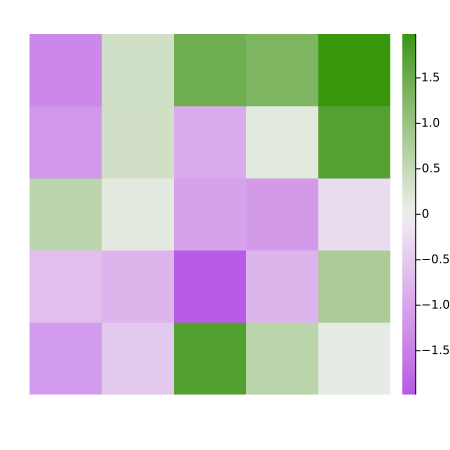

In [164]:
A = randn(m,m)
scale = maximum(abs.(A))
imshow(A, clim=(-scale, scale), size=(450,450))

3.181193405905584e-15

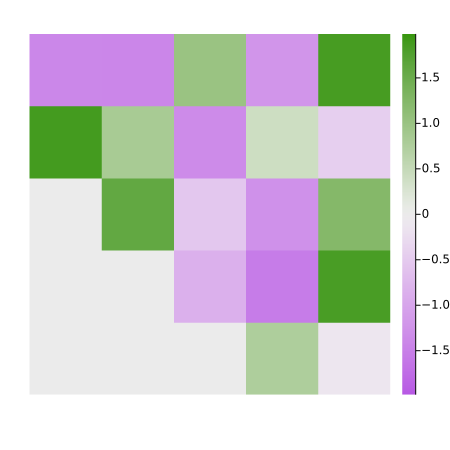

In [187]:
Q, H = householder_to_hessenberg(A)
display(norm(Q * H * Q' - A))
imshow(H, clim=(-scale, scale), size=(450,450))

### Operation Count

In [185]:
function householder_to_hessenberg(A)
    m = size(A)[1]
    Q = Matrix(one(eltype(A))*I,m,m)
    H = copy(A)
    for k in 1:m-2
        x = H[k+1:m,k]
        vₖ = copy(x)
        vₖ[1] += norm(x) * sign(x[1])
        vₖ /= norm(vₖ)
        H[k+1:m,k:m] -= 2 * vₖ * (vₖ' * H[k+1:m,k:m]) # ~ 4 (m-k) (m-k-1)
        H[1:m,k+1:m] -= 2 * (H[1:m,k+1:m] * vₖ) * vₖ' # ~ 4 m (m-k)
        Q[:,k+1:m] = Q[:,k+1:m] * (I - 2 * vₖ * vₖ')
    end
    return Q, H
end

householder_to_hessenberg (generic function with 1 method)

- Line 10: $\sum_{k=1}^{m-2} 4(m-k)(m-k-1) \sim 4 \int_0^m k^2\ dk = \frac{4}{3} m^3.$

- Line 11: $\sum_{k=1}^{m-2} 4 m (m-k) \sim 4 m \int_0^m k\ dk = 2 m^3$

- $\Rightarrow \frac{10}{3} m^3$ flops

### The Hermitian Case: Reduction to Tridiagonal Form

In [193]:
function householder_to_triangular(A)
    m = size(A)[1]
    Q = Matrix(one(eltype(A))*I,m,m)
    H = copy(A)
    for k in 1:m-2
        x = H[k+1:m,k]
        vₖ = copy(x)
        vₖ[1] += norm(x) * sign(x[1])
        vₖ /= norm(vₖ)
        H[k+1:m,k:m] -= 2 * vₖ * (vₖ' * H[k+1:m,k:m]) # Qₖ' on left
        H[k:m,k+1:m] -= 2 * (H[k:m,k+1:m] * vₖ) * vₖ' # Qₖ on right
        Q[:,k+1:m] = Q[:,k+1:m] * (I - 2 * vₖ * vₖ')
    end
    return Q, H
end

householder_to_triangular (generic function with 1 method)

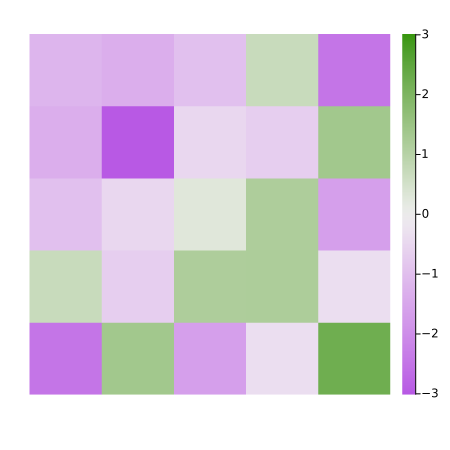

In [199]:
A = randn(m,m)
A = A + A'
scale = maximum(abs.(A))
imshow(A, clim=(-scale, scale), size=(450,450))

2.4905893207998803e-15

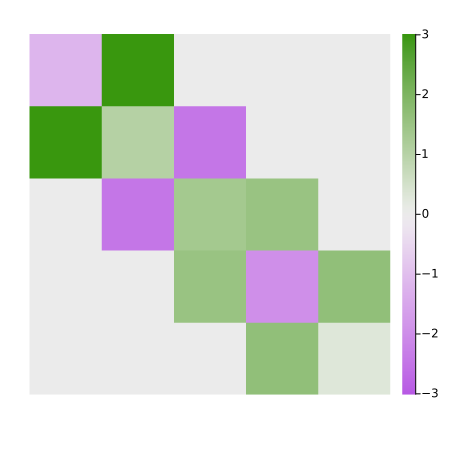

In [200]:
Q, H = householder_to_triangular(A)
display(norm(Q * H * Q' - A))
imshow(H, clim=(-scale, scale), size=(450,450))

In [193]:
function householder_to_triangular(A)
    m = size(A)[1]
    Q = Matrix(one(eltype(A))*I,m,m)
    H = copy(A)
    for k in 1:m-2
        x = H[k+1:m,k]
        vₖ = copy(x)
        vₖ[1] += norm(x) * sign(x[1])
        vₖ /= norm(vₖ)
        H[k+1:m,k:m] -= 2 * vₖ * (vₖ' * H[k+1:m,k:m]) # 4 (m-k)(m-k-1)
        H[k:m,k+1:m] -= 2 * (H[k:m,k+1:m] * vₖ) * vₖ' # 4 (m-k-1)(m-k)
        Q[:,k+1:m] = Q[:,k+1:m] * (I - 2 * vₖ * vₖ')
    end
    return Q, H
end

householder_to_triangular (generic function with 1 method)

### Operation Count

- $\sim 2 \frac{4}{3} m^3 = \frac{8}{3} m^3$, but this doesn't take advantage of symmetry
- This can be exploited to reduce by half the number of updated entries, $\frac{4}{3}m^3$ work

### Stability

**Theorem 26.1.** Let the Hessenberg reduction $A = QHQ^*$ of a matrix $A \in C^{m \times m}$ be computed by `householder_to_hessenberg` on a computer satisfying the floating point axioms, and let the computed factors $\tilde{Q}$ and $\tilde{H}$ be computed factors, with $\tilde{Q}$ the exact product of exactly unitary Householder reflectors from computed $\tilde{v}_k$.  Then

$$
\tilde{Q} \tilde{H} \tilde{Q}^* = A + \delta A, \quad \frac{\|\delta A\|}{\|A\|} = O(\epsilon_{\text{machine}})
$$

for some $\delta A$.